# scRNA-seq Imputation

**Data**

Endoderm Cell data:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748

Mouse organ tissue data:

Smart-seq2 https://doi.org/10.6084/m9.figshare.5715040.v1 ( Consortium, The Tabula Muris, 2017a).

10X Chromium https://doi.org/10.6084/m9.figshare.5715040.v1 ( Consortium, The Tabula Muris, 2017b).


**R packages**

MAGIC: Rmagic (v0.1.0) https://github.com/KrishnaswamyLab/MAGIC

DrImpute: DrImpute (v1.0) https://github.com/ikwak2/DrImpute

scImpute: scImpute(v0.0.8) https://github.com/Vivianstats/scImpute

SAVER: SAVER(v1.0.0) https://github.com/mohuangx/SAVER

Knn-smooth: knn_smooth.R (Version 2) https://github.com/yanailab/knn-smoothing

Splatter (data simulation): splatter(v1.2.2) : https://bioconductor.org/packages/release/bioc/html/splatter.html


**Python packages**

Dca : dca(v0.2.2): https://github.com/theislab/dca

scDMFK: https://github.com/xuebaliang/scDMFK





In [1]:
import os
import pandas as pd
import numpy as np
import h5py
import scipy as sp
import scanpy as sc

In [2]:
## Clustering
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scDMFK.io import get_embedding, draw_umap
from scDMFK.preprocess import *

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-16 22:15:53.055625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## 1. Definite endoderm cells (DECs)

The single cell expression data of DECs are obtained from the GEO website (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748). The dataset includes the RNA expression count data of 1018 single cells from snapshot progenitors.

The paper for analysis of the dataset: Single-cell RNA-seq reveals novel regulators of human embryonic stem cell differentiation to definitive endoderm. https://pubmed.ncbi.nlm.nih.gov/27534536/

In [11]:
file_path =  os.getcwd() + '/data/endoderm/endoderm.csv'
endoderm = pd.read_csv(file_path, index_col=0)
endoderm = endoderm.T
endoderm.head()
# cell labels
end_label = [label.split("_")[0] for label in endoderm.index.to_list()]

In [3]:
## Endoderm dataset
adata = prepro('endoderm/endoderm.csv')
adata = adata.transpose()
adata = normalize(adata, highly_genes=None, size_factors=True, normalize_input=True, logtrans_input=True)
adata.obs

Successfully preprocessed 1018 genes and 19097 cells


,n_counts,size_factors
H1_Exp1.001,1494450.0,0.339551
H1_Exp1.002,2169089.0,0.492834
H1_Exp1.003,1727355.0,0.392469
H1_Exp1.004,1391420.0,0.316142
H1_Exp1.006,1419963.0,0.322627
...,...,...
TB_Batch2.140,3975507.0,0.903267
TB_Batch2.141,3979547.0,0.904185
TB_Batch2.142,6002437.0,1.363801
TB_Batch2.143,5583433.0,1.268600


### Denoising scRNA-seq data with DCA

In [ ]:
!python -m dca.__main__ data/endoderm/endoderm.csv data/endoderm/results/

"The tight clusters of overlapped H1 and H9 single cells indicated the relative homogeneity of human ES cells compared to the rest of the progenitors" 

-- Chu et al. (2016)

### scDMFK

In [4]:
# datanames = ['endoderm', 'Young',
#              'Quake_10x_Bladder','Quake_10x_Limb_Muscle', 'Quake_10x_Spleen',
#              'sim/group10_dropout1', 'sim/group10_dropout5']
out = 'endoderm'
data = out + '/endoderm.csv'
methods = ['multinomial','ZINB', 'weight mse', 'mask mse']
for m in methods:
    print('Processing: %s' % m)
    !python scDMFK/run.py --dataname {data} --outputdir {out} --pretrain_epoch 300 --model {m} --transpose True
    

Processing: multinomial
Using TensorFlow backend.
Successfully preprocessed 19097 genes and 1018 cells
Creating new scDMFK model
2024-04-20 15:03:33.090465: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-20 15:03:33.223613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 15:03:33.233528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
Traceback (most recent call last):
  File "scDMFK/run.py", line 81, in <module>
    scDenoising.pretrain(adata, size_factor, 
TypeError: pretrain() takes 6 positional arguments but 7 were given
Processing: ZINB
Using TensorFlow ba

In [21]:
!python scDMFK/run.py --dataname "endoderm/endoderm.csv" --outputdir "endoderm" --transpose True --pretrain_epoch 300

Using TensorFlow backend.
Successfully preprocessed 1018 genes and 19097 cells
begin training
2024-04-18 21:58:06.201498: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-18 21:58:06.201721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
begin the pretraining

2024-04-18 21:58:06.360939: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
Epoch 1/300
4/4 [==============================] - 2s 303ms/step - loss: 3382.8094
Epoch 2/300
4/4 [==============================] - 1s 252ms/step - loss: 3243.1459
Epoch 3/300
4/4 [==============================] - 1s 252ms/step - loss: 3149.39550

### DEC: Clustering with UMAP

In [5]:
endoderm

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,MYL2,UBE2Z,RGPD4,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,10,6,0,0,0,84,0,0,18,0,...,84,0,0,0,239,101,0,22,32,0
H1_Exp1.002,162,2,28,133,7,5,0,0,146,4,...,40,0,0,187,231,201,0,84,52,0
H1_Exp1.003,3,166,0,41,52,305,0,0,106,0,...,21,0,0,6,169,23,0,19,110,0
H1_Exp1.004,42,9,1,0,20,41,0,0,9,0,...,12,0,0,49,90,164,0,52,73,1
H1_Exp1.006,0,7,0,0,0,142,0,0,14,5,...,41,0,0,26,240,181,0,2,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,5,23,0,206,0,46,0,0,74,0,...,185,0,0,7,0,5,146,0,221,0
TB_Batch2.141,500,362,0,43,56,90,0,0,15,0,...,156,0,0,0,251,79,539,296,166,0
TB_Batch2.142,18,22,3,2,2,562,0,0,25,0,...,10,0,0,28,0,6,0,0,131,0
TB_Batch2.143,472,36,39,1,0,778,0,0,225,2,...,719,0,0,211,2,124,21,271,730,0


/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


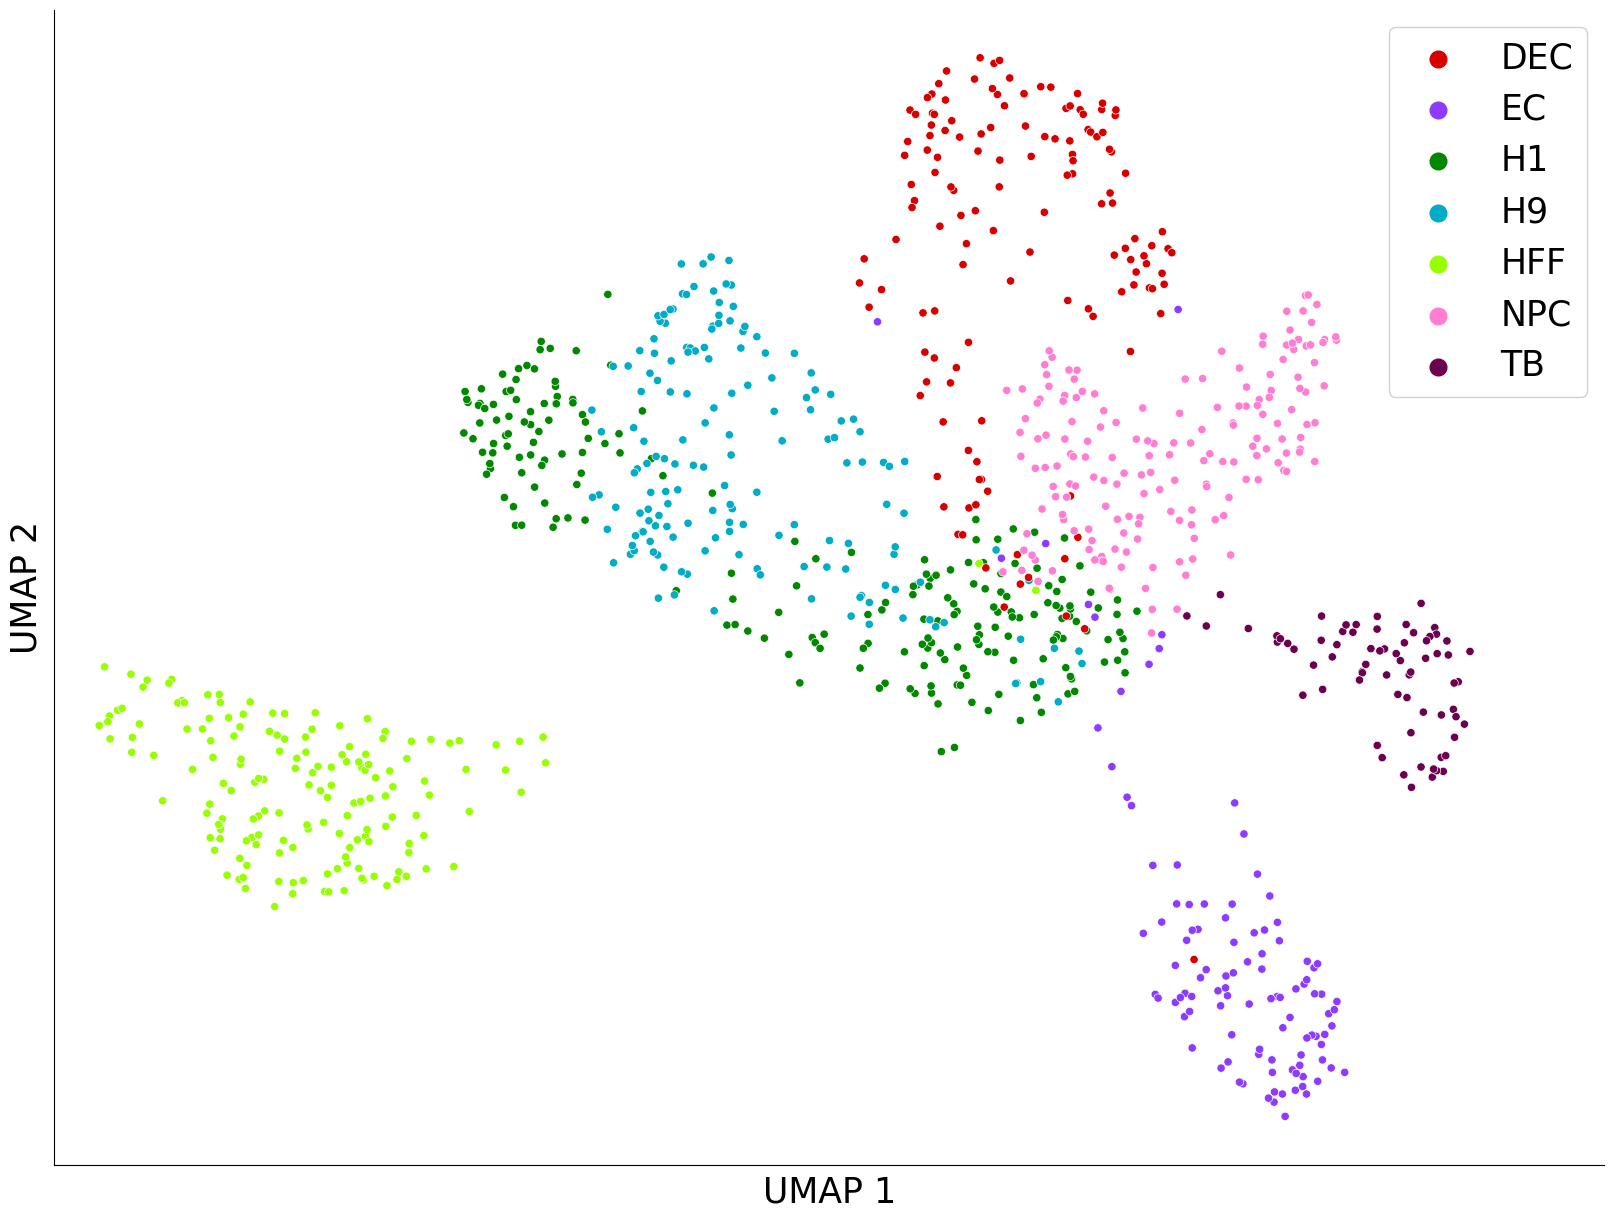

In [7]:
# Raw data: clustering 
np.random.seed(1111)
end_embedding = get_embedding(endoderm.values)
draw_umap(end_embedding, label)

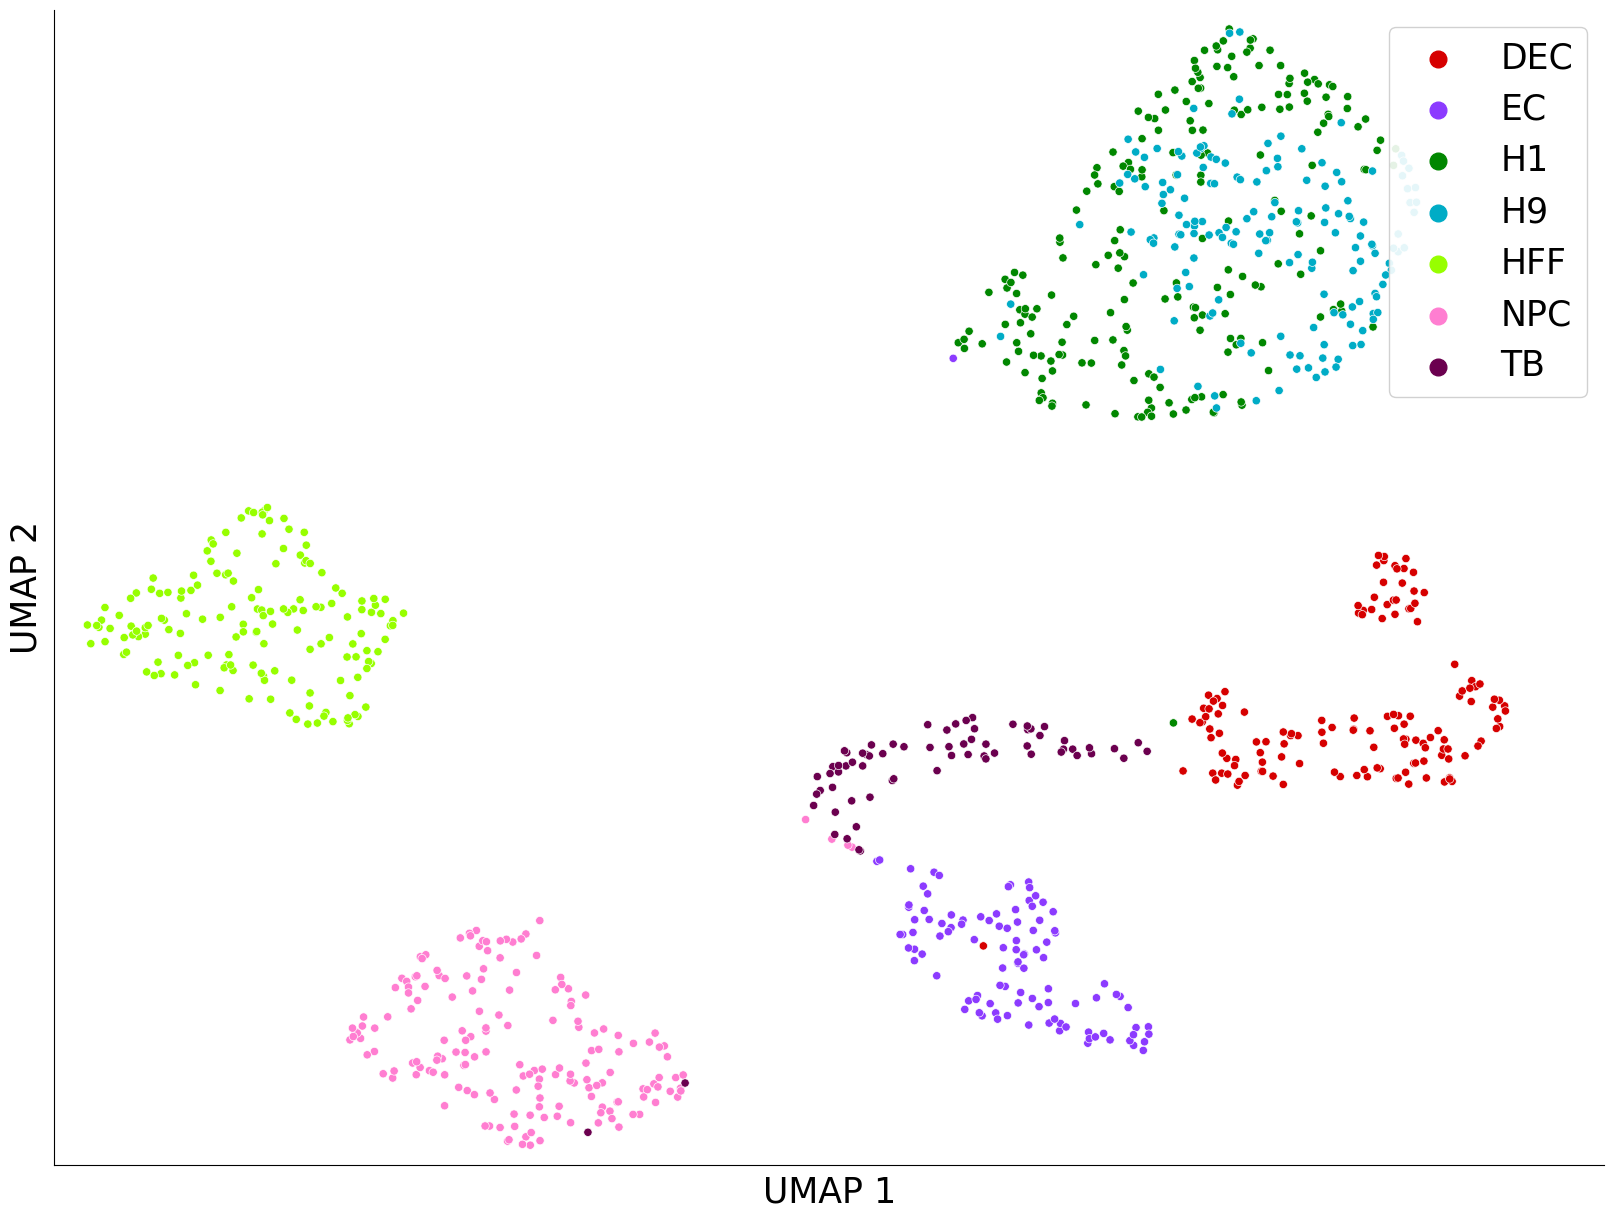

In [59]:
# DCA results: clustering 
endoderm_dn_dca = pd.read_csv('data/endoderm/mean.tsv', sep='\t', index_col=0)
endoderm_dn_dca = endoderm_dn_dca.T

end_dca_emb = get_embedding(endoderm_dn_dca)
draw_umap(end_dca_emb, end_label)

In [7]:
endoderm_dn = pd.read_csv(os.getcwd()+'/data/endoderm/results/mean-scdm-100.csv', index_col=0)
endoderm_dn

,APOA2,HIST1H2BC,RSPH9,MT-ND4,HIST1H4F,TNNT2,GSDMD,FBXL17,DDI2,FBXO41,...,ADAMTS7,TCEANC,ITGA9,LRRC2,PDE11A,CCDC144NL,SYDE1,NTNG1,DDA1,EPSTI1
ABTB1,,,,,,,,,,,,,,,,,,,,,
0.438825,0.027483,0.430194,0.447294,125312.00,0.377874,0.454996,345.16196,75.238240,0.408071,0.438677,...,0.380860,497.34354,0.033735,1800.7762,537.41693,0.425166,0.416457,0.387655,1208.5359,253.90968
0.743746,0.040953,0.720511,0.748923,223602.08,0.649278,0.761907,437.99655,156.042240,0.686383,0.743377,...,0.631700,676.44820,0.042480,2872.5176,733.29200,0.708645,0.704752,0.666990,1535.3749,231.41936
0.611622,0.023360,0.594723,0.611113,185444.62,0.516441,0.626109,345.02237,78.457054,0.566482,0.614306,...,0.513077,481.48608,0.043379,2229.1233,495.26044,0.583788,0.581821,0.550306,1113.5233,233.76602
0.558161,0.024459,0.555252,0.566325,152409.17,0.485783,0.576244,332.95972,90.590454,0.522065,0.562487,...,0.470185,311.41130,0.037786,1728.8982,665.71680,0.542071,0.536128,0.495722,958.0881,139.21283
0.450509,0.021982,0.440262,0.450571,113861.16,0.386732,0.462832,322.68134,125.227330,0.408796,0.449866,...,0.375258,465.75317,0.036756,1590.9453,621.13074,0.423600,0.433556,0.393033,1065.2163,239.91420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.749556,0.016460,0.753257,0.712196,116126.05,0.470587,0.797138,678.14374,556.861500,0.740039,0.789898,...,0.619047,370.06890,0.154875,1759.5829,807.53894,0.753798,0.681821,0.552042,3167.7742,4496.66200
0.740303,0.035294,0.755460,0.720767,91189.78,0.522001,0.816061,1129.98440,750.180900,0.746614,0.797403,...,0.631337,761.63170,0.187403,3322.0657,1948.79690,0.747965,0.674389,0.575999,4653.2427,3634.10470
1.059017,0.020624,1.071837,0.996228,177616.58,0.690317,1.122462,593.02200,649.869140,1.052646,1.115376,...,0.871568,512.40470,0.205727,2306.5212,829.28470,1.050997,0.959565,0.765163,4313.1694,7206.30300


/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


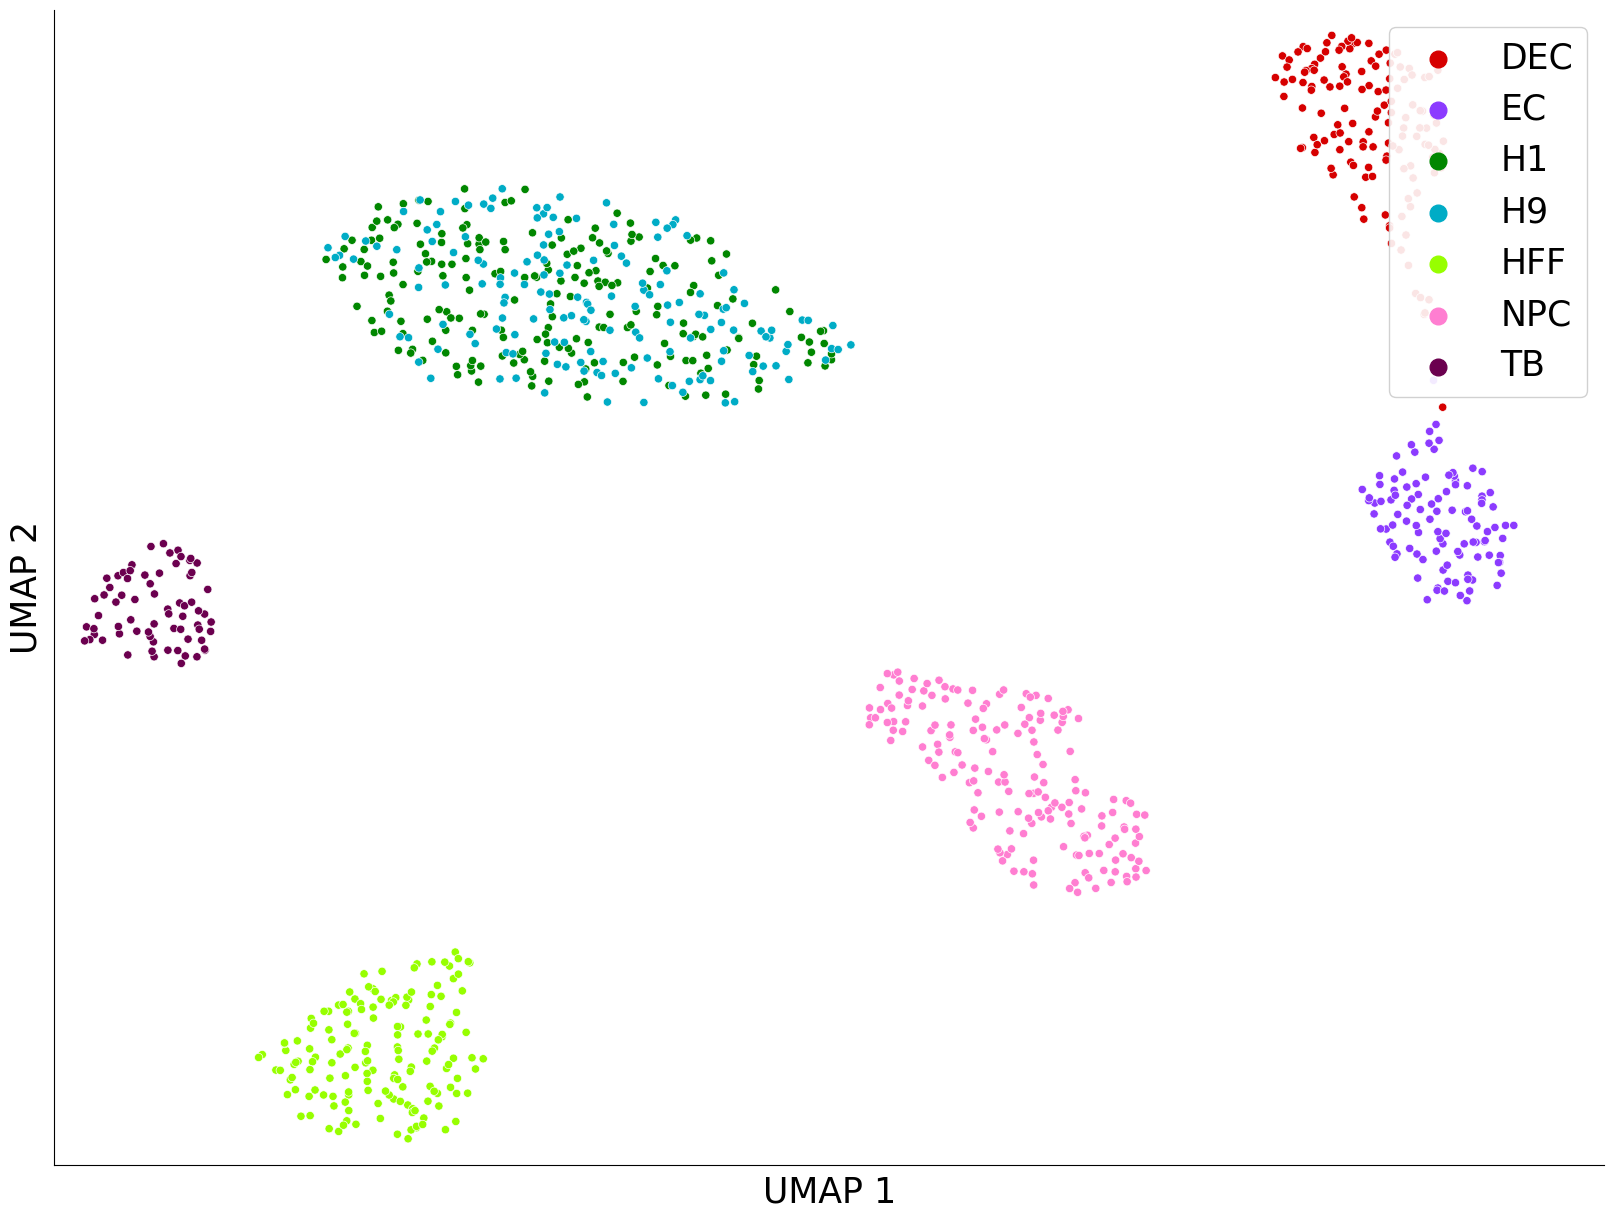

In [62]:
# scDM results: clustering
np.random.seed(2222)
end_scdm_embedding = get_embedding(endoderm_dn.values)
draw_umap(end_scdm_embedding, label)

## 2. Mouse Tissue Datasets

### Young dataset

In [49]:
!python scDMFK/run.py --dataname "Young/data.h5" --outputdir "Young/" --pretrain_epoch 300

Using TensorFlow backend.
Successfully preprocessed 33658 genes and 5685 cells
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
begin training
2024-04-18 22:31:45.731735: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-18 22:31:45.736145: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
begin the pretraining

2024-04-18 22:31:46.053239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
Epoch 1/300
23/23

In [7]:
# Young dataset
young = prepro('Young/data.h5')
young = normalize(young, highly_genes=500, size_factors=True, normalize_input=True, logtrans_input=True)

# cell labels
young_label = young.obs['Group']

Successfully preprocessed 33658 genes and 5685 cells


In [10]:
# scDM results
young_dn = pd.read_csv("data/Young/results/mean-dmfk.csv", index_col=0)
young_dn.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,20.252222,-3.050400,-5.257073,5.367495,-6.135241,4.301290,0.264685,-5.117161,21.135019,-4.376247,...,8.573717,-1.388716,-5.255368,-8.244027,-24.653364,-3.256777,6.143616,0.251498,-9.319720,-18.576248
1,19.100042,-6.458814,-13.335517,8.719076,-15.052866,5.832477,4.440654,-8.136289,15.768123,-9.041668,...,-2.267433,-2.058186,-8.391916,-6.999797,-21.431467,-3.384575,1.142257,1.367146,-0.078503,-14.129859
2,11.118900,-4.066586,-18.860926,9.312256,-15.624731,6.280530,2.529792,-9.828175,20.873371,-4.223153,...,-1.641458,-7.061494,-15.245840,-6.457023,-11.292294,-6.389202,12.438574,-7.944099,-1.417301,-12.398549
3,15.808970,2.486598,-10.851238,3.723683,-13.879186,0.665575,4.113214,-6.126764,17.866220,-5.559927,...,1.768394,-3.482606,-6.893301,-5.796049,-20.133636,-7.044637,6.088548,-6.230302,-3.199679,-16.213264
4,13.032480,-2.593959,-9.294227,4.111813,-5.860040,4.046119,-6.919588,-4.087893,16.413116,-4.577088,...,1.936125,-3.053966,-5.675722,-4.195628,-18.431461,-1.564938,4.320317,-5.356950,-9.355852,-19.277306


### Young: Clustering with UMAP

In [3]:
# Raw data: clustering

# np.random.seed(1111)
# young_emb = get_embedding(young.X)
# draw_umap(young_emb, young_label)

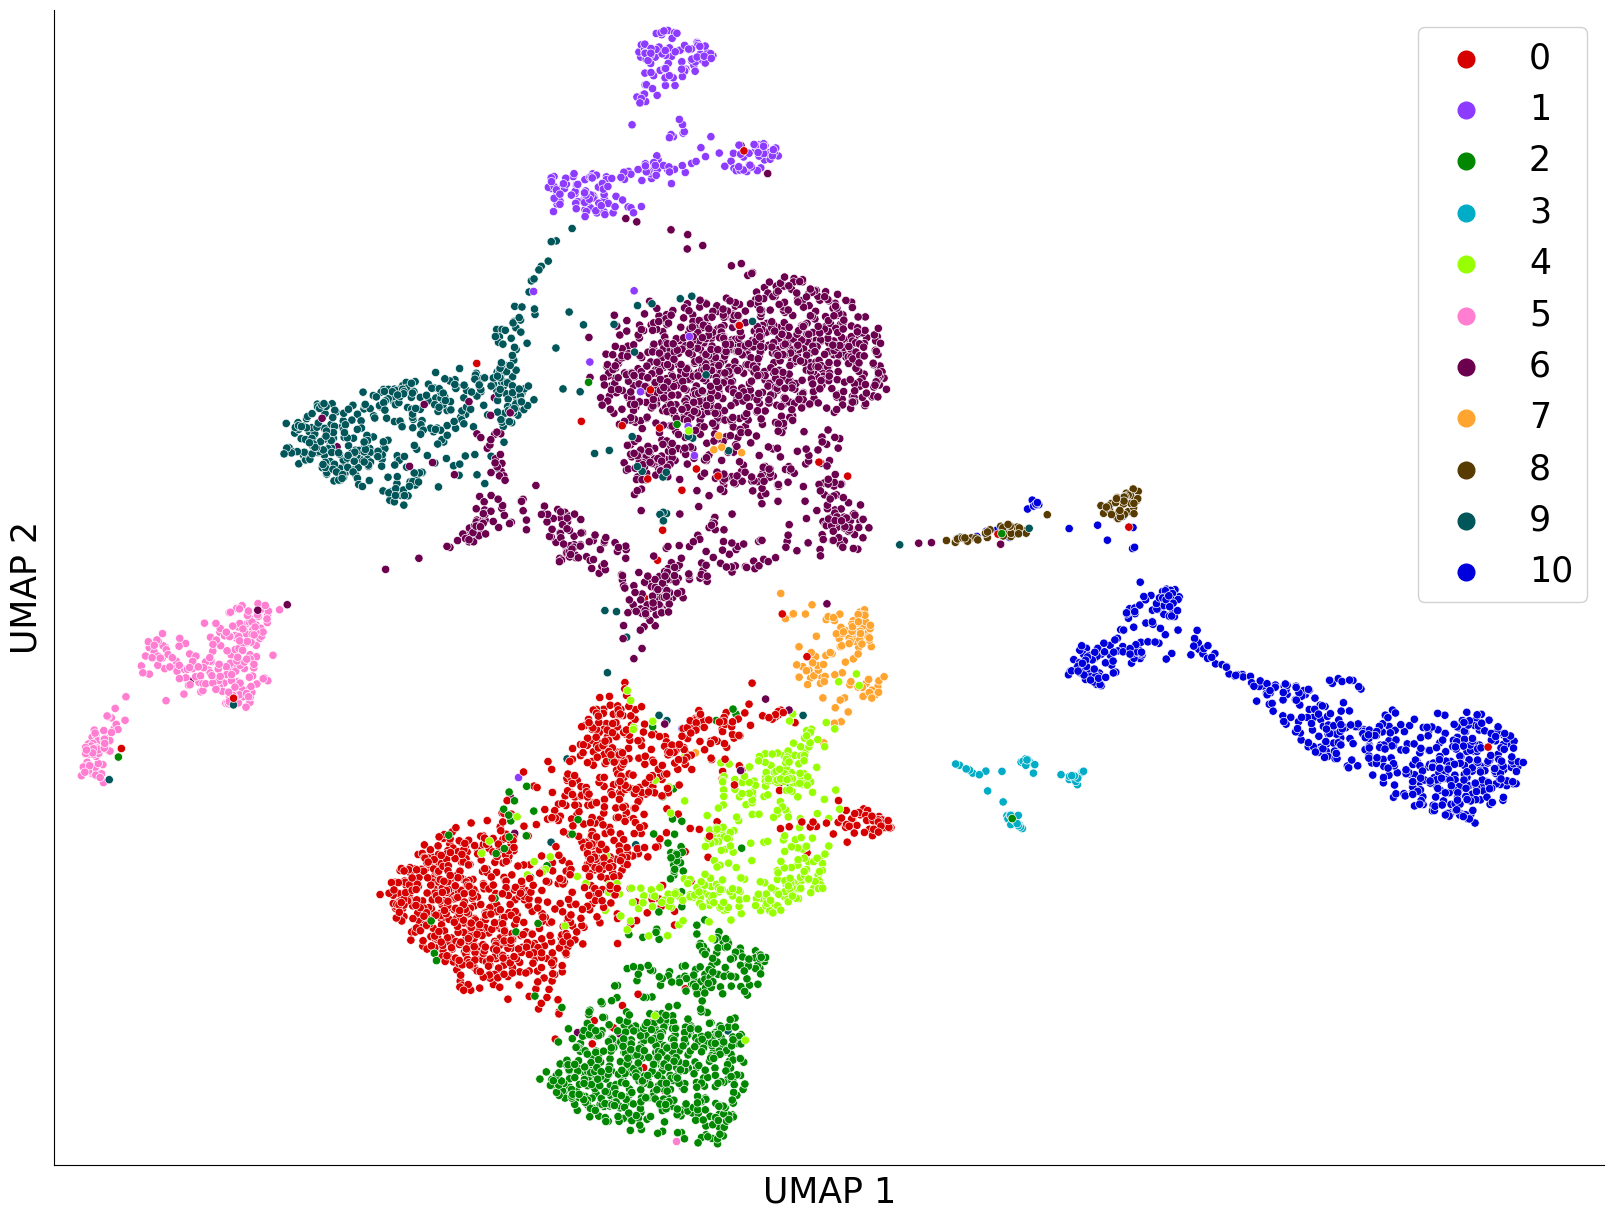

In [8]:
np.random.seed(1111)
young_scdm_emb = get_embedding(young_dn.values)
draw_umap(young_scdm_emb, young_label)

### Bladder Dataset

In [12]:
!python scDMFK/run.py --dataname "Quake_10x_Bladder/data.h5" --outputdir "Quake_10x_Bladder/results/" --pretrain_epoch 1000

2024-04-14 18:47:38.796537: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
non-resource variables are not supported in the long term
Successfully preprocessed 23341 genes and 2500 cells
begin training
begin the pretraining
2024-04-14 18:47:48.674141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:47:48.674709: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-14 18:47:48.675498: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


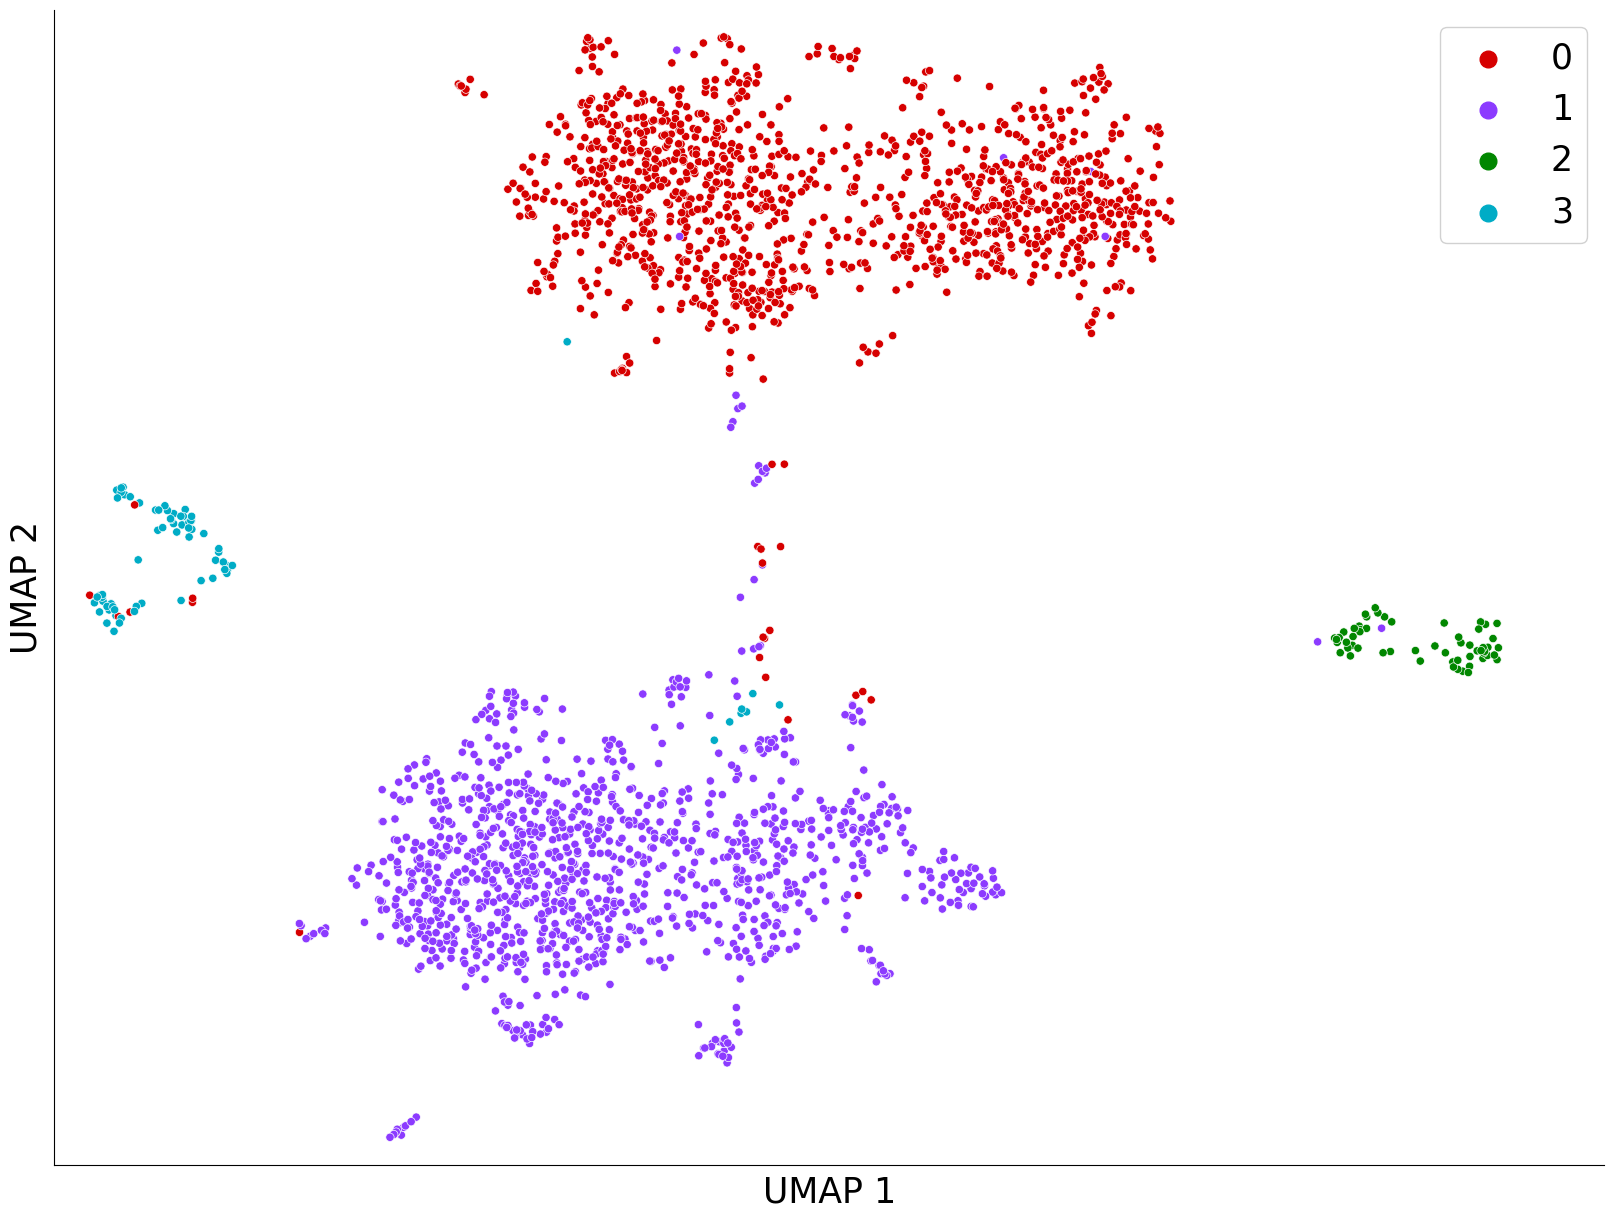

In [19]:
# Bladder data
filename = "Quake_10x_Bladder"
filepath = filename + '/data.h5'
bladder = prepro(filepath)
bladder = normalize(bladder, highly_genes=500, size_factors=True, normalize_input=True, logtrans_input=True)
# Cell labels
bladder_label = bladder.obs['Group']

# Denoised data
denoise_path = 'data/' + filename + '/results/mean-dmfk.csv'
bladder_dn = pd.read_csv(denoise_path, index_col=0)

np.random.seed(1111)
bladder_emb = get_embedding(bladder.X)
draw_umap(bladder_emb, bladder_label)

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


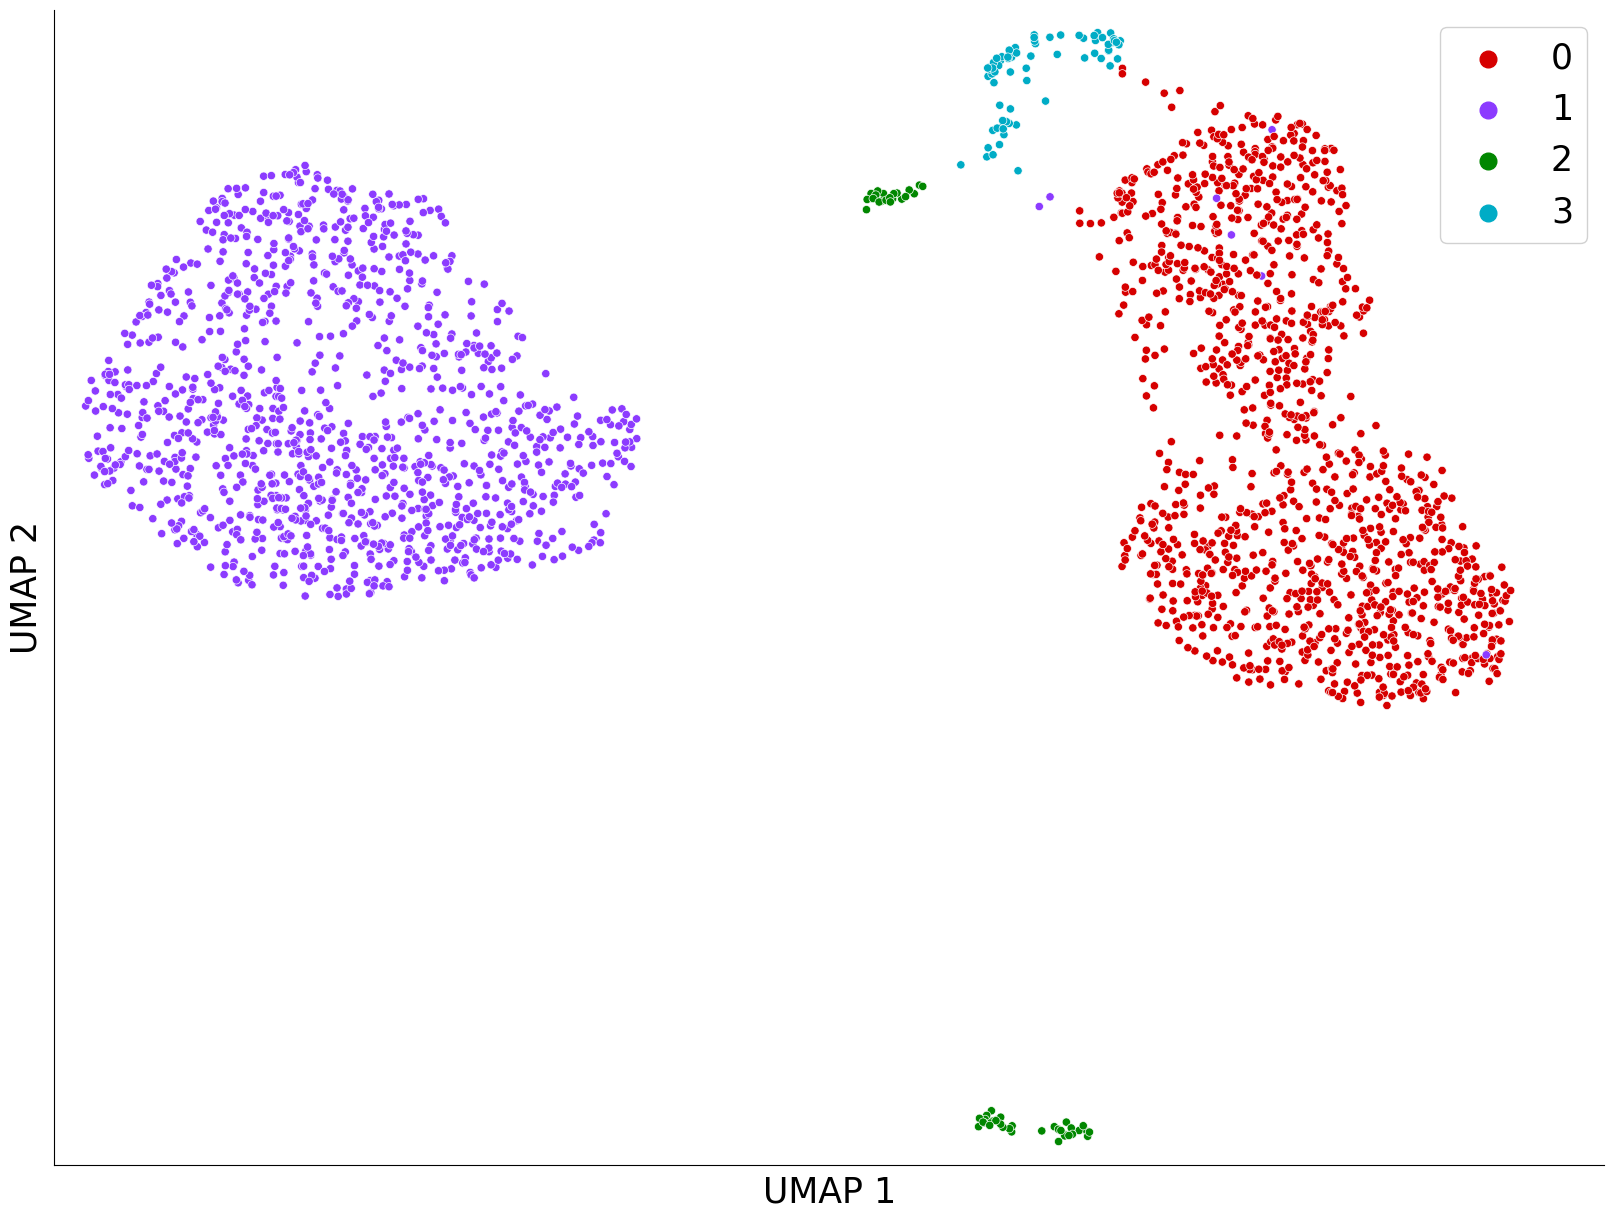

In [20]:
# scDM results: clustering
np.random.seed(1111)
bladder_scdm_emb = get_embedding(bladder_dn.values)
draw_umap(bladder_scdm_emb, bladder_label)

### Spleen

In [3]:
!python scDMFK/run.py --dataname "Quake_10x_Spleen/data.h5" --pretrain_epoch 10

2024-04-15 21:39:50.967008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
non-resource variables are not supported in the long term
Successfully preprocessed 23341 genes and 9552 cells
begin training
begin the pretraining
2024-04-15 21:40:37.713488: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 21:40:37.730394: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-15 21:40:38.132562: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such

In [1]:
# Spleen
filename = "Quake_10x_Spleen"
filepath = filename + '/data.h5'
spleen = prepro(filepath)
spleen = normalize(spleen, highly_genes=500, size_factors=True, normalize_input=True, logtrans_input=True)
# Cell labels
spleen_label = spleen.obs['Group']

# Denoised data
denoise_path = 'data/' + filename + '/results/latent-scdm.csv'
spleen_dn = pd.read_csv(denoise_path, index_col=0)

np.random.seed(1111)
spleen_emb = get_embedding(spleen.X)
draw_umap(spleen_emb, spleen_label)

## 3. Simulated data

In [1]:
# datanames = ['endoderm', 'Young',
#              'Quake_10x_Bladder','Quake_10x_Limb_Muscle', 'Quake_10x_Spleen',
#              'sim/group10_dropout1', 'sim/group10_dropout5']
out = 'group10_dropout1'
data = out + '/counts.tsv'
methods = ['multinomial','ZINB', 'weight mse', 'mask mse']
for m in methods:
    print('Processing: %s' % m)
    !python scDMFK/run.py --dataname {data} --outputdir {out} --pretrain_epoch 300 --model {m} --transpose True
    

Processing: multinomial
Using TensorFlow backend.
Successfully preprocessed 200 genes and 2000 cells
begin training
Creating new scDMFK model
2024-04-20 10:58:55.861970: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-20 10:58:56.065783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 10:58:56.077169: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
Begin the pretraining...

Traceback (most recent call last):
  File "scDMFK/run.py", line 84, in <module>
    scDenoising.pretrain(adata, size_factor, args.batch_size, args.pretrain_epoch, args.gpu_option)
  File "/Us

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import scipy as sp
from dca.api import dca, normalize

from sklearn.metrics import silhouette_score

sc.settings.set_figure_params(dpi=120)

Using TensorFlow backend.


In [14]:
sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw.obs_names = cellinfo.Cell
sim_raw.var_names = geneinfo.Gene
sim_raw.var_names
dropout


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,Gene10,...,Gene191,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200
Cell1,1,0,1,0,1,0,0,0,0,1,...,1,0,0,1,1,0,0,0,1,0
Cell2,0,1,1,0,1,1,1,0,0,1,...,1,0,0,1,1,0,0,1,1,0
Cell3,1,0,1,1,1,0,1,1,0,1,...,1,0,0,1,1,1,0,1,1,1
Cell4,0,1,1,0,1,0,0,1,1,1,...,1,0,0,1,1,1,0,0,1,1
Cell5,1,1,1,0,1,1,1,0,0,1,...,1,0,1,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell1996,1,1,1,0,1,0,0,1,1,1,...,1,1,1,1,1,0,0,0,1,1
Cell1997,1,1,1,1,0,0,0,1,1,1,...,1,1,1,1,1,1,1,0,1,1
Cell1998,1,1,1,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,0,1,1
Cell1999,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,1,0,0,0,1,1


In [13]:
data = 'group2_dropout5'
# data
truecounts = pd.read_csv('data/' + data + '/info_truecounts.tsv', sep='\t',index_col=0).T
counts = pd.read_csv('data/' + data + '/counts.tsv', sep='\t',index_col=0).T
dropout = pd.read_csv('data/' + data + '/info_dropout.tsv', sep='\t').T
cellinfo = pd.read_csv('data/' + data + '/info_cellinfo.tsv', sep='\t')
geneinfo = pd.read_csv('data/' + data + '/info_geneinfo.tsv', sep='\t')

sim_raw = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
sim_raw.obs_names = cellinfo.Cell
sim_raw.var_names = geneinfo.Gene
sc.pp.filter_genes(sim_raw, min_counts=1)

# remove zero-genes from dropout data frame too
dropout_gt = dropout.loc[:, sim_raw.var_names].values

sim_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
sim_true.obs_names = cellinfo.Cell
sim_true.var_names = geneinfo.Gene
sim_true = sim_true[:, sim_raw.var_names].copy()
sim_true

sim_raw_norm = sim_raw.copy()
sc.pp.normalize_total(sim_raw_norm)
sc.pp.log1p(sim_raw_norm)
sc.pp.pca(sim_raw_norm)

sim_true_norm = sim_true.copy()
sc.pp.normalize_total(sim_true_norm)
sc.pp.log1p(sim_true_norm)
sc.pp.pca(sim_true_norm)

print(dropout_gt[:10, :10])
print(sim_raw)
print(sim_true)

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[[1 0 1 0 1 0 0 0 0 1]
 [0 1 1 0 1 1 1 0 0 1]
 [1 0 1 1 1 0 1 1 0 1]
 [0 1 1 0 1 0 0 1 1 1]
 [1 1 1 0 1 1 1 0 0 1]
 [1 1 1 0 1 1 0 0 1 1]
 [1 1 1 0 1 1 0 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 0 1 0 1 0 0 1]]
AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
AnnData object with n_obs × n_vars = 2000 × 195
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'


In [15]:
%%time

dca_zinb = dca(sim_raw, threads=1, copy=True, log1p=False, return_info=True, verbose=False, random_state=42)

dca_zinb_norm = dca_zinb.copy()
sc.pp.normalize_total(dca_zinb_norm)
sc.pp.log1p(dca_zinb_norm)
sc.pp.pca(dca_zinb_norm)

dca: Successfully preprocessed 200 genes and 2000 cells.


AssertionError: Please remove all-zero genes before using DCA.

In [ ]:
# Cell labels
sim_label = bladder.obs['Group']

# Denoised data
denoise_path = 'data/' + filename + '/results/mean-dmfk.csv'
bladder_dn = pd.read_csv(denoise_path, index_col=0)

np.random.seed(1111)
bladder_emb = get_embedding(bladder.X)
draw_umap(bladder_emb, bladder_label)